# Autoencoder for Predictive Maintenance

This notebook implements an autoencoder on the MetroPT dataset for predictive maintenance. 

Source of dataset: https://zenodo.org/record/6854240#.Y8v4PMnMJD8

In [121]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the dataset
df = pd.read_csv("dataset_train.zip", delimiter=',')

In [3]:
# Convert timestamp to a Datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst='True')

# Feature Extraction
This section does the feature extraction for training. The compressor could be in 3 modes:
a. Not active
b. Working but not loaded
c. Working and loaded

Based on the motor current values, these modes can be identified. A training example is generated with the mean values in a time duration where the mode remains constant.

In this section, the training dataset is generated by identifying the timeframe for which the compressor is in the same mode of operation and obtaining the mean values of the variables during the timeframe.

In [180]:
X_train = []
date_train_min = datetime.datetime(2022,2,1)
date_train_max = datetime.datetime(2022,2,27)
thresh_motor_curr = 0.5
thresh_min_motor_curr_comp_load = 4.7

In [185]:
iter = 0
while (True):
    if (df['timestamp'].iloc[iter] >= date_train_min and df['timestamp'].iloc[iter] <= date_train_max):
        iter_start       = iter
        timestamp_start  = df['timestamp'].iloc[iter]
        motor_curr_start = df['Motor_current'].iloc[iter]
        while (abs(df['Motor_current'].iloc[iter] - motor_curr_start) <= thresh_motor_curr or\
               (motor_curr_start > thresh_min_motor_curr_comp_load and \
                (df['Motor_current'].iloc[iter] > thresh_min_motor_curr_comp_load))):
            iter = iter + 1
    
        iter_end       = iter - 1       
        time_stamp_end = df['timestamp'].iloc[iter_end]
        mean_analog    = df[['TP2','TP3','H1','DV_pressure','Reservoirs','Oil_temperature','Flowmeter','Motor_current']].\
               iloc[iter_start:iter_end].mean(axis=0)
        mean_digital   = df[['COMP','DV_eletric','Towers','MPG','LPS','Pressure_switch','Oil_level','Caudal_impulses']].\
               iloc[iter_start:iter_end].mean(axis=0)
        delta_t        = (df['timestamp'].iloc[iter_end] - df['timestamp'].iloc[iter_start]).total_seconds() 
        if delta_t > 0.0:
            tmp_a = pd.concat([mean_analog, mean_digital], axis = 0)
            tmp_a = tmp_a.to_list()
            tmp_a.append(delta_t)
            X_train.append(tmp_a)
    else:
        if(df['timestamp'].iloc[iter] < date_train_min):
            iter = iter + 1
        else:
            break

In [186]:
np.shape(X_train)

(6765, 17)

In [212]:
n_cols_train    = np.shape(X_train)[1]

In [279]:
# Scale the training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Model: Building and Training
An autoencoder model is built. 
The input has 16 elements - the mean data from 8 analog and 8 digital sensors for the specific timeframe where the compressor is a particular mode of operation.
The encoder has 3 hidden layers with 128, 64 and 32 neurons each. The bottleneck layer has 12 neurons. The decoder architecture mirrors the encoder architecture and consists of 3 layers with 32, 64 and 128 neurons each.

ReLu activation function is used in the hidden layers. The output layer uses linear activation function.

Adam optimiser is used for training.

In [188]:
# Some model parameters
n_output = np.shape(X_train)[1]
n_layers_encoder = [128, 64, 32]
n_layer_bottleneck = 12
len_encoder = len(n_layers_encoder)

n_epoch = 300
n_batch = 1000

In [189]:
# The loss function with a wrapper
def ret_loss_function():
    def custom_loss_function(y_true_dummy, y_pred):
        mse = tf.reduce_mean(tf.square(y_true_dummy - y_pred), axis = -1)
        return mse
    return custom_loss_function

In [190]:
model = Sequential()
model.add(tf.keras.layers.Dense(n_layers_encoder[0], input_dim = n_output, activation='relu'))
for i in range(1,len_encoder):
    model.add(Dense(n_layers_encoder[i], activation='relu'))
model.add(Dense(n_layer_bottleneck, activation='relu'))
for i in range(0,len_encoder):
    model.add(Dense(n_layers_encoder[len_encoder-i-1], activation='relu'))
model.add(Dense(n_output, activation='linear'))

In [191]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               2304      
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 12)                396       
                                                                 
 dense_21 (Dense)            (None, 32)                416       
                                                                 
 dense_22 (Dense)            (None, 64)                2112      
                                                                 
 dense_23 (Dense)            (None, 128)             

In [192]:
#-------------------------------------------------------------
# Compile model
#-------------------------------------------------------------
model.compile(loss=ret_loss_function(), optimizer='adam', metrics=['mse'], run_eagerly=True)


In [193]:
#-------------------------------------------------------------
# Fit the model
#-------------------------------------------------------------
history = model.fit(X_train_scaled, X_train_scaled, epochs=n_epoch, batch_size=n_batch, verbose=1)

Epoch 1/300
7/7 [==============================] - 0s 42ms/step - loss: 0.2568 - mse: 0.2568
Epoch 2/300
7/7 [==============================] - 0s 36ms/step - loss: 0.1886 - mse: 0.1886
Epoch 3/300
7/7 [==============================] - 0s 37ms/step - loss: 0.0773 - mse: 0.0773
Epoch 4/300
7/7 [==============================] - 0s 36ms/step - loss: 0.0461 - mse: 0.0461
Epoch 5/300
7/7 [==============================] - 0s 37ms/step - loss: 0.0223 - mse: 0.0223
Epoch 6/300
7/7 [==============================] - 0s 36ms/step - loss: 0.0151 - mse: 0.0151
Epoch 7/300
7/7 [==============================] - 0s 38ms/step - loss: 0.0134 - mse: 0.0134
Epoch 8/300
7/7 [==============================] - 0s 39ms/step - loss: 0.0121 - mse: 0.0121
Epoch 9/300
7/7 [==============================] - 0s 41ms/step - loss: 0.0113 - mse: 0.0113
Epoch 10/300
7/7 [==============================] - 0s 38ms/step - loss: 0.0105 - mse: 0.0105
Epoch 11/300
7/7 [==============================] - 0s 39ms/step - lo

7/7 [==============================] - 0s 36ms/step - loss: 5.2759e-04 - mse: 5.2759e-04
Epoch 86/300
7/7 [==============================] - 0s 36ms/step - loss: 5.0444e-04 - mse: 5.0444e-04
Epoch 87/300
7/7 [==============================] - 0s 37ms/step - loss: 4.8718e-04 - mse: 4.8718e-04
Epoch 88/300
7/7 [==============================] - 0s 37ms/step - loss: 4.7237e-04 - mse: 4.7237e-04
Epoch 89/300
7/7 [==============================] - 0s 37ms/step - loss: 4.6134e-04 - mse: 4.6134e-04
Epoch 90/300
7/7 [==============================] - 0s 37ms/step - loss: 4.4996e-04 - mse: 4.4996e-04
Epoch 91/300
7/7 [==============================] - 0s 35ms/step - loss: 4.4307e-04 - mse: 4.4307e-04
Epoch 92/300
7/7 [==============================] - 0s 38ms/step - loss: 4.3465e-04 - mse: 4.3465e-04
Epoch 93/300
7/7 [==============================] - 0s 35ms/step - loss: 4.2800e-04 - mse: 4.2800e-04
Epoch 94/300
7/7 [==============================] - 0s 38ms/step - loss: 4.1760e-04 - mse: 4.17

7/7 [==============================] - 0s 37ms/step - loss: 1.6018e-04 - mse: 1.6018e-04
Epoch 165/300
7/7 [==============================] - 0s 37ms/step - loss: 1.5966e-04 - mse: 1.5966e-04
Epoch 166/300
7/7 [==============================] - 0s 37ms/step - loss: 1.6317e-04 - mse: 1.6317e-04
Epoch 167/300
7/7 [==============================] - 0s 37ms/step - loss: 1.5348e-04 - mse: 1.5348e-04
Epoch 168/300
7/7 [==============================] - 0s 37ms/step - loss: 1.4630e-04 - mse: 1.4630e-04
Epoch 169/300
7/7 [==============================] - 0s 37ms/step - loss: 1.4926e-04 - mse: 1.4926e-04
Epoch 170/300
7/7 [==============================] - 0s 38ms/step - loss: 1.4623e-04 - mse: 1.4623e-04
Epoch 171/300
7/7 [==============================] - 0s 38ms/step - loss: 1.4347e-04 - mse: 1.4347e-04
Epoch 172/300
7/7 [==============================] - 0s 38ms/step - loss: 1.4844e-04 - mse: 1.4844e-04
Epoch 173/300
7/7 [==============================] - 0s 35ms/step - loss: 1.4649e-04 - 

7/7 [==============================] - 0s 39ms/step - loss: 6.1108e-05 - mse: 6.1108e-05
Epoch 244/300
7/7 [==============================] - 0s 37ms/step - loss: 8.0607e-05 - mse: 8.0607e-05
Epoch 245/300
7/7 [==============================] - 0s 37ms/step - loss: 7.7063e-05 - mse: 7.7063e-05
Epoch 246/300
7/7 [==============================] - 0s 37ms/step - loss: 6.9364e-05 - mse: 6.9364e-05
Epoch 247/300
7/7 [==============================] - 0s 37ms/step - loss: 6.2447e-05 - mse: 6.2447e-05
Epoch 248/300
7/7 [==============================] - 0s 35ms/step - loss: 6.0079e-05 - mse: 6.0079e-05
Epoch 249/300
7/7 [==============================] - 0s 35ms/step - loss: 6.5441e-05 - mse: 6.5441e-05
Epoch 250/300
7/7 [==============================] - 0s 39ms/step - loss: 6.0584e-05 - mse: 6.0584e-05
Epoch 251/300
7/7 [==============================] - 0s 38ms/step - loss: 5.9140e-05 - mse: 5.9140e-05
Epoch 252/300
7/7 [==============================] - 0s 39ms/step - loss: 6.1519e-05 - 

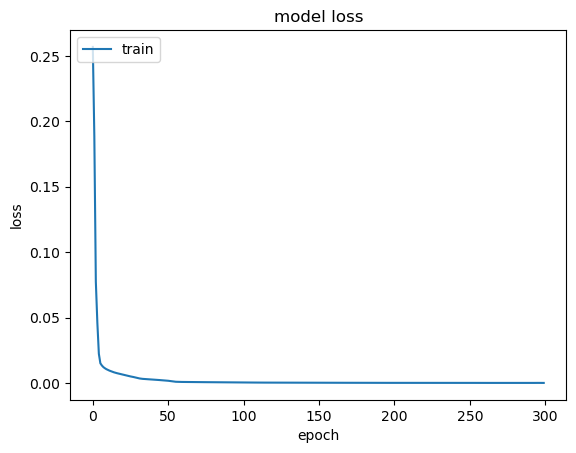

In [194]:
#-------------------------------------------------------------
# Summarize history for loss
#-------------------------------------------------------------
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

We can see from the above curve that the mean square error has dropped considerably during the training process.

# Choosing the threshold for anomaly classification
The following section deals with choosing a threshold value, based on which certain inputs would be classified as anomalous and otherwise. For example, if the mean squared error between the input to the model and its output is greater than this threshold value, we consider that as anomalous.

In [217]:
n_elem_train           = np.shape(X_train_scaled)[0]  # Number of elements in training dataset
n_elem_choose_thresh   = 0.3 * n_elem_train    # Number of elements in the dataset used for choosing a threshold
index_set_choose_thresh = np.random.randint(0, n_elem_train, int(n_elem_choose_thresh) )  # Choosing the indices from the training dataset randomly

In [218]:
# Picking the chosen indices from training dataset
X_thresh_set = np.array(X_train_scaled)[index_set_choose_thresh]

In [219]:
# Getting the mse for the set of points identified
Y_thresh_set = model.predict(np.reshape(X_thresh_set, [int(n_elem_choose_thresh), n_cols_train]))
mse_thresh_set = tf.reduce_mean(tf.square(Y_thresh_set - X_thresh_set), axis = -1)                           

64/64 [==============================] - 0s 3ms/step


{'whiskers': [<matplotlib.lines.Line2D at 0x251e743a4c0>,
 'caps': [<matplotlib.lines.Line2D at 0x251e743aa60>,
 'boxes': [<matplotlib.lines.Line2D at 0x251e743a1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x251e7410040>],
 'fliers': [<matplotlib.lines.Line2D at 0x251e7410310>],
 'means': []}

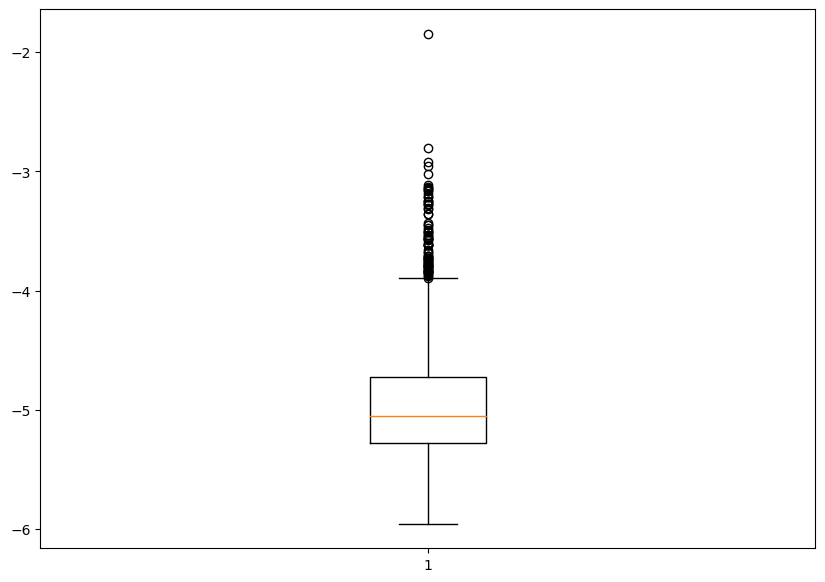

In [222]:
# Making a boxplot
fig = plt.figure(figsize =(10, 7))
plt.boxplot(np.log10(mse_thresh_set))

From the above plot, we can choose threshold value to be 10^-3 as a warning for probable failure and a value of 10^-2 for confirming failure.

In [197]:
# Writing the training data to a file for future use
np.savetxt("file1.txt", X_train)

# Testing with known anomalies
The training of the autoencoder has been done using data from 1st Febraury 2022 to 27th February 2022. Now the sensor data fron 28th Febraury 2022 to 2nd Match 2022 is used to test the model. 

In the documentation regarding the dataset (https://www.nature.com/articles/s41597-022-01877-3/tables/3),  3 actual failures have been provided for testing the model. One of them occured on 28th February 2022. From the testing in this section, we can identify if the trained model can capture the anomaly.

In [311]:
X_test = []
t_test_info = []
date_test_min = datetime.datetime(2022,2,28)
date_test_max = datetime.datetime(2022,3,2)

In [312]:
iter = 0
while (True):
    if (df['timestamp'].iloc[iter] >= date_test_min and df['timestamp'].iloc[iter] <= date_test_max):
        iter_start       = iter
        timestamp_start  = df['timestamp'].iloc[iter]
        motor_curr_start = df['Motor_current'].iloc[iter]
        while (abs(df['Motor_current'].iloc[iter] - motor_curr_start) <= thresh_motor_curr or\
               (motor_curr_start > thresh_min_motor_curr_comp_load and \
                (df['Motor_current'].iloc[iter] > thresh_min_motor_curr_comp_load))):
            iter = iter + 1
    
        iter_end       = iter - 1       
        time_stamp_end = df['timestamp'].iloc[iter_end]
        mean_analog    = df[['TP2','TP3','H1','DV_pressure','Reservoirs','Oil_temperature','Flowmeter','Motor_current']].\
               iloc[iter_start:iter_end].mean(axis=0)
        mean_digital   = df[['COMP','DV_eletric','Towers','MPG','LPS','Pressure_switch','Oil_level','Caudal_impulses']].\
               iloc[iter_start:iter_end].mean(axis=0)
        delta_t        = (df['timestamp'].iloc[iter_end] - df['timestamp'].iloc[iter_start]).total_seconds() 
        if delta_t > 0.0:
            tmp_a = pd.concat([mean_analog, mean_digital], axis = 0)
            tmp_a = tmp_a.to_list()
            tmp_a.append(delta_t)
            X_test.append(tmp_a)
            tmp_t_info = [timestamp_start, time_stamp_end]
            t_test_info.append(tmp_t_info)
            
    else:
        if(df['timestamp'].iloc[iter] < date_test_min):
            iter = iter + 1
        else:
            break

In [314]:
# Scale the test data
X_test_scaled = scaler.transform(X_test)

In [315]:
# Getting the mse for the test daa
Y_test_scaled = model.predict(X_test_scaled) # np.reshape(X_test_scaled, [np.shape(X_test_scaled)[0], n_cols_train]))
mse_test = tf.reduce_mean(tf.square(Y_test_scaled - X_test_scaled), axis = -1) 

14/14 [==============================] - 0s 11ms/step


(array([19051.  , 19051.25, 19051.5 , 19051.75, 19052.  , 19052.25,
        19052.5 , 19052.75, 19053.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

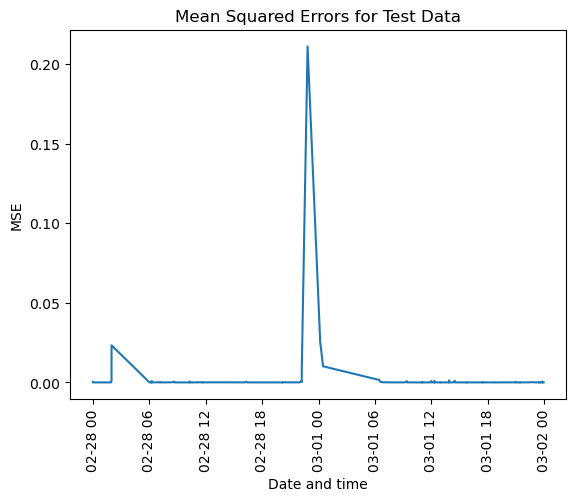

In [330]:
plt.plot(np.array(t_test_info)[:,0],mse_test)
plt.title('Mean Squared Errors for Test Data')
plt.xlabel('Date and time')
plt.ylabel('MSE')
plt.xticks(rotation=90)

It is clear from the above plot that there is a drastic increase in mean square error to a value of 0.2 at 22:50 of 28th February 2022. As per our threshold criteria, the MSE exceeded 10^-3 at 22:12 hrs predicting a failure. As per the documentation (https://www.nature.com/articles/s41597-022-01877-3/tables/3), the failure occured at 21:53 hrs. Thus, our model could succesfullly identify the failure within a lag of 21 minutes. 

Efforts to reduce the lag can be tried by tuning the hyperparameters (the number of hidden layers, neurons in each layer and so on). Also, instead of using a single example containing the mean values for the complete iterval when the compressor remains in a mode of operation, we can divide the segment to a number of sub-intervals. This might reduce the lag in prediction.

From the above figure, we can also notice a small peak in the early morning of 28th February 2022. This may also be providing a warning for an upcoming failure.

In [317]:
# Identifying index where MSE is maximum
max_index = np.argmax(mse_test)
t_test_info[max_index]

[Timestamp('2022-02-28 22:50:10'), Timestamp('2022-03-01 00:10:36')]

In [328]:
# Displaying time and mse around the peak
t_test_info[max_index-5:max_index+10], mse_test[max_index-5:max_index+10]

([[Timestamp('2022-02-28 21:53:58'), Timestamp('2022-02-28 22:00:52')],
  [Timestamp('2022-02-28 22:00:53'), Timestamp('2022-02-28 22:12:55')],
  [Timestamp('2022-02-28 22:12:56'), Timestamp('2022-02-28 22:12:58')],
  [Timestamp('2022-02-28 22:12:59'), Timestamp('2022-02-28 22:13:02')],
  [Timestamp('2022-02-28 22:13:03'), Timestamp('2022-02-28 22:50:08')],
  [Timestamp('2022-02-28 22:50:10'), Timestamp('2022-03-01 00:10:36')],
  [Timestamp('2022-03-01 00:10:37'), Timestamp('2022-03-01 00:28:52')],
  [Timestamp('2022-03-01 00:28:53'), Timestamp('2022-03-01 06:27:43')],
  [Timestamp('2022-03-01 06:27:44'), Timestamp('2022-03-01 06:34:38')],
  [Timestamp('2022-03-01 06:34:39'), Timestamp('2022-03-01 06:55:02')],
  [Timestamp('2022-03-01 06:55:04'), Timestamp('2022-03-01 06:55:09')],
  [Timestamp('2022-03-01 06:55:10'), Timestamp('2022-03-01 06:56:53')],
  [Timestamp('2022-03-01 06:56:55'), Timestamp('2022-03-01 07:03:48')],
  [Timestamp('2022-03-01 07:03:50'), Timestamp('2022-03-01 07:21

In [350]:
# Writing result files
np.savetxt("x_test.txt", X_test)
np.savetxt("mse_test.txt", mse_test)

In [361]:
# Writing result files
fid = open("t_test_info.txt",'w')
for i in range(np.shape(t_test_info)[0]):
    date = t_test_info[i][0]
    fid.write(date.strftime("%d-%b-%Y %H:%M:%S.%f"))
    date = t_test_info[i][1]
    fid.write(date.strftime("\t%d-%b-%Y %H:%M:%S.%f\n"))
    
fid.close()